<a href="https://colab.research.google.com/github/asalcedo31/CSC2516_project/blob/master/L0_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.utils.model_zoo as model_zoo
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn.modules import Module
import torchvision.models.vgg as tv_vgg
import time
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
import time
import os
import re
import copy
import math
from collections import OrderedDict

from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

% cd /content/gdrive/My Drive/meta_pruning


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/meta_pruning


In [0]:
class DatasetManager:
    
    def __init__(self, dataset='cifar10', percent_data=10.0, percent_val=20.0, batch_size=5):
        
        # 'dataset' can be 'cifar10', 'cifar100', 'mnist', 'fashionmnist', 'kmnist', 'emnist', 'stl10', 'svhn'.
        # 'percent_data' is the percentage of the full training set to be used.
        # 'percent_val' is the percentage of the *loaded* training set to be used as validation data.
        self.dataset = dataset
        self.data_path = 'data/{}'.format(dataset)
        self.percent_data = percent_data
        self.percent_val = percent_val
        self.batch_size = batch_size
        
        if self.dataset == 'hymenoptera':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            
        elif self.dataset == 'cifar10' or\
             self.dataset == 'cifar100' or\
             self.dataset == 'stl10' or\
             self.dataset == 'svhn':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        elif self.dataset == 'mnist' or\
             self.dataset == 'fashionmnist' or\
             self.dataset == 'kmnist' or\
             self.dataset == 'emnist':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        return
    
    
    def ImportDataset(self, batch_size=5):
        
        self.batch_size = batch_size
        
        if self.dataset == 'hymenoptera':
        
            self.trainset = tv.datasets.ImageFolder(root=os.path.join(self.data_path, "train"),
                             transform=self.transform)
            self.valset = tv.datasets.ImageFolder(os.path.join(self.data_path, "val"),
                             transform=self.transform)
        
            self.testset = None
        # todo
        
        elif self.dataset == 'cifar10':

            self.trainset = tv.datasets.CIFAR10(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.CIFAR10(root=self.data_path, train=False,
                                       download=True, transform=self.transform)
        
        elif self.dataset == 'cifar100':

            self.trainset = tv.datasets.CIFAR100(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.CIFAR100(root=self.data_path, train=False,
                                       download=True, transform=self.transform)
             
        elif self.dataset == 'mnist':

            self.trainset = tv.datasets.MNIST(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.MNIST(root=self.data_path, train=False,
                                       download=True, transform=self.transform)

        elif self.dataset == 'fashionmnist':

            self.trainset = tv.datasets.FashionMNIST(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.FashionMNIST(root=self.data_path, train=False,
                                       download=True, transform=self.transform)

        elif self.dataset == 'kmnist':

            self.trainset = tv.datasets.KMNIST(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.KMNIST(root=self.data_path, train=False,
                                       download=True, transform=self.transform)

        elif self.dataset == 'emnist':

            self.trainset = tv.datasets.EMNIST(root=self.data_path, split='balanced', train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.EMNIST(root=self.data_path, split='balanced', train=False,
                                       download=True, transform=self.transform)

        elif self.dataset == 'stl10':

            self.trainset = tv.datasets.STL10(root=self.data_path, split='train',
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.STL10(root=self.data_path, split='test',
                                       download=True, transform=self.transform)

        elif self.dataset == 'svhn':

            self.trainset = tv.datasets.SVHN(root=self.data_path, split='train',
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.SVHN(root=self.data_path, split='test',
                                       download=True, transform=self.transform)

        if self.percent_data < 100:
          self.SplitData();
        self.GenerateLoaders();
                
        return
    
    
    def SplitData(self):
        
        len_full = self.trainset.__len__()
        len_train = int(np.round(len_full*self.percent_data/100.0))
        
        _, self.trainset = torch.utils.data.random_split(self.trainset, (len_full-len_train, len_train))
        
        len_val = int(np.round(len_train*self.percent_val/100.0))
        len_train = len_train - len_val
        
        self.valset, self.trainset = torch.utils.data.random_split(self.trainset, (len_val, len_train))
        
        print('\nFull training set size: {}'.format(len_full))        
        print('\nActive training set size: {}'.format(len_train))
        print('Active validation set size: {}'.format(len_val))
        
        if self.testset is not None:
          len_full_test = self.testset.__len__()
          len_test = int(np.round(len_full_test*self.percent_data/100.0))
        
          _, self.testset = torch.utils.data.random_split(self.testset, (len_full_test-len_test, len_test)) 
          print('Full test set size: {}'.format(len_full_test))
          print('Active test set size: {}\n'.format(len_test))
        
        return
    
    
    def GenerateLoaders(self):
        
        self.train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        self.val_loader = torch.utils.data.DataLoader(self.valset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        if self.testset is not None:
          self.test_loader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)          
            
        return
    
    def DataSamples(self,num_samples=800):
      shuffled_train = torch.utils.data.RandomSampler(self.trainset)
      self.train_sample_list = list(torch.utils.data.BatchSampler(shuffled_train,num_samples,False))
      
    def GetDataSample(self):      
      for i in range(len(self.train_sample_list)):
        yield self.train_sample_list[i]
      
    def GetDataSampleLoader(self,num_samples=800):
        
        DS = self.GetDataSample()
        train_sample = [trainset[j] for j in DS] 

        train_data, val_data = torch.utils.data.random_split(train_sample,(int(0.8*num_samples),int(0.2*num_samples)))

        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        self.val_loader = torch.utils.data.DataLoader(val_data, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
    

In [0]:
def freeze_layers(model_ft, exclude=[]):
#   children = list(model_ft.named_children())
  for name,param in model_ft.named_parameters():   
    if(name not in  exclude):
      param.requires_grad = False

In [0]:
def train_model_prune_old(model, dloaders, dataset_sizes, criterion, optimizer, scheduler,prop=0.05, num_epochs=25, device='cuda',pruning='threshold'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print(len(dloaders['train']))
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                data_idx = 0
            else:
                model.eval()   # Set model to evaluate mode
                data_idx = 1

            running_loss = 0.0
            running_corrects = 0
            i=0
            
#             print(dloaders[phase].__iter__().next())
            # Iterate over data.
            for inputs, labels in dloaders[phase]:               
#                 print("batch {} phase {}".format(i, phase))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    if pruning == 'L0':
                      loss = criterion(outputs, labels,model)
                    else:
                      loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        model.clamp_parameters()
                        exp_flops, exp_l0 = model.get_exp_flops_l0()
                i+=1
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                           
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if epoch % 5 == 0 and phase == 'train': 
              if pruning == 'threshold':
                set_threshold(model,prop=prop)
              elif pruning == 'L0':
                print(exp_flops.item(), exp_l0.item())
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return epoch_loss

In [0]:
def train_model_prune_new(model, dat, criterion, optimizer, scheduler, tracker, prop=0.01, num_epochs=25, device='cuda',pruning='threshold'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print(dat.trainset.__len__())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                data_idx = 0
                dataloader = dat.train_loader
                dataset_size = dat.trainset.__len__()
                
            else:
                model.eval()   # Set model to evaluate mode
                data_idx = 1
                dataloader = dat.val_loader
                dataset_size = dat.valset.__len__()


            running_loss = 0.0
            running_corrects = 0
            i=0
            
#             print(dloaders[phase].__iter__().next())
            # Iterate over data.
            for inputs, labels in dataloader:               
#                 print("batch {} phase {}".format(i, phase))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    if pruning == 'L0':
                      loss = criterion(outputs, labels,model)
                    else:
                      loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if pruning == 'L0':
                          model.clamp_parameters()
                          exp_flops, exp_l0 = model.get_exp_flops_l0()
                i+=1
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                           
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if epoch % 5 == 0 and phase == 'train': 
              if pruning == 'threshold':
                set_threshold(model, tracker, prop=prop)
              elif pruning == 'L0':
                print(exp_flops.item(), exp_l0.item())
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            tracker = RecordLosses(phase, epoch_loss, epoch_acc, tracker)
            if phase == 'val' and pruning == 'L0':
              tracker.flops.append(exp_flops.item())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    tracker.outer_iter_time.append(time_elapsed)
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
limit_a, limit_b, epsilon = -.1, 1.1, 1e-6
device='cuda'

class LinearL0(Module):
  """Implementation of L0 regularization for the input units of a fully connected layer"""
  def __init__(self, in_features, out_features, bias=True, weight_decay=1., droprate_init=0.5, temperature=2./3.,
                 lamba=1., local_rep=False, qz_loga=None, **kwargs):
        """
        :param in_features: Input dimensionality
        :param out_features: Output dimensionality
        :param bias: Whether we use a bias
        :param weight_decay: Strength of the L2 penalty
        :param droprate_init: Dropout rate that the L0 gates will be initialize d to
        :param temperature: Temperature of the concrete distribution
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(LinearL0, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_prec = weight_decay
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features).to(device))
#         self.qz_loga = torch.Tensor(in_features).to(device)
        self.qz_loga = torch.nn.Parameter(torch.Tensor(in_features).to(device))
        self.temperature = temperature
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        self.lamba = lamba
        self.use_bias = False
        self.local_rep = local_rep
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features).to(device))
            self.use_bias = True
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
        self.reset_parameters()
        if qz_loga is not None:
          self.qz_loga = qz_loga

  def reset_parameters(self):
      torch.nn.init.kaiming_normal(self.weight, mode='fan_out')
      self.qz_loga.data.normal_(math.log(1 - self.droprate_init) - math.log(self.droprate_init), 1e-2)

      if self.use_bias:
          self.bias.data.fill_(0)

  def constrain_parameters(self, **kwargs):
      self.qz_loga.data.clamp_(min=math.log(1e-2), max=math.log(1e2))

  def cdf_qz(self, x):
      """Implements the CDF of the 'stretched' concrete distribution"""
      xn = (x - limit_a) / (limit_b - limit_a)
      logits = math.log(xn) - math.log(1 - xn)
      return F.sigmoid(logits * self.temperature - self.qz_loga).clamp(min=epsilon, max=1 - epsilon).to(device)

  def quantile_concrete(self, x):
      """Implements the quantile, aka inverse CDF, of the 'stretched' concrete distribution"""
      y = F.sigmoid((torch.log(x) - torch.log(1 - x) + self.qz_loga) / self.temperature).to(device)
      return y * (limit_b - limit_a) + limit_a

  def _reg_w(self):
      """Expected L0 norm under the stochastic gates, takes into account and re-weights also a potential L2 penalty"""
      logpw_col = torch.sum(- (.5 * self.prior_prec * self.weight.pow(2)) - self.lamba, 1).to(device)
      logpw = torch.sum((1 - self.cdf_qz(0)) * logpw_col).to(device)
      logpb = 0 if not self.use_bias else - torch.sum(.5 * self.prior_prec * self.bias.pow(2)).to(device)
      return logpw + logpb

  def regularization(self):
      return self._reg_w()

  def count_expected_flops_and_l0(self):
      """Measures the expected floating point operations (FLOPs) and the expected L0 norm"""
      # dim_in multiplications and dim_in - 1 additions for each output neuron for the weights
      # + the bias addition for each neuron
      # total_flops = (2 * in_features - 1) * out_features + out_features
      ppos = torch.sum(1 - self.cdf_qz(0))
      expected_flops = (2 * ppos - 1) * self.out_features
      expected_l0 = ppos * self.out_features
      if self.use_bias:
          expected_flops += self.out_features
          expected_l0 += self.out_features
#       return expected_flops.data[0], expected_l0.data[0]
      return expected_flops, expected_l0

  def get_eps(self, size):
      """Uniform random numbers for the concrete distribution"""
      eps = self.floatTensor(size).uniform_(epsilon, 1-epsilon).to(device)
      eps = Variable(eps)
      return eps

  def sample_z(self, batch_size, sample=True):
      """Sample the hard-concrete gates for training and use a deterministic value for testing"""
      if sample:
          eps = self.get_eps(self.floatTensor(batch_size, self.in_features))
          z = self.quantile_concrete(eps)
          return F.hardtanh(z, min_val=0, max_val=1).to(device)
      else:  # mode
          pi = F.sigmoid(self.qz_loga).view(1, self.in_features).expand(batch_size, self.in_features).to(device)
          return F.hardtanh(pi * (limit_b - limit_a) + limit_a, min_val=0, max_val=1).to(device)

  def sample_weights(self):
      z = self.quantile_concrete(self.get_eps(self.floatTensor(self.in_features)))
      mask = F.hardtanh(z, min_val=0, max_val=1).to(device)
      return mask.view(self.in_features, 1) * self.weight

  def forward(self, input):
      if self.local_rep or not self.training:
          z = self.sample_z(input.size(0), sample=self.training)
          xin = input.mul(z)
          output = xin.mm(self.weight)
      else:
          weights = self.sample_weights()
          output = input.mm(weights)
      if self.use_bias:
          output.add_(self.bias)
      return output

  def __repr__(self):
      s = ('{name}({in_features} -> {out_features}, droprate_init={droprate_init}, '
           'lamba={lamba}, temperature={temperature}, weight_decay={prior_prec}, '
           'local_rep={local_rep}')
      if not self.use_bias:
          s += ', bias=False'
      s += ')'
      return s.format(name=self.__class__.__name__, **self.__dict__)

In [0]:

def mask_network(network,layers_to_mask, n=None, lamba=0.1, threshold=float("-inf"), linear_masking=None,random_init=False, bias=True,masks=None):
  """"
  replaces linear layers with masked linear layers
  network is the initial sequential container
  layers is a list of layers to mask
  random init is a logical indicating whether to preserve the initial weights or to modify them
  """
  network.masked_layers=[]
  for name,layer in network.named_children():   
    if int(name) in layers_to_mask:
      layer_mask = None
      if masks is not None:
        if name in masks:
          layer_mask = masks.get(name)      
      if type(layer)== torch.nn.Linear and linear_masking is None:
        masked_layer = MaskedLinear(layer.in_features, layer.out_features, bias=bias,threshold=threshold,mask=layer_mask)
      elif type(layer)== torch.nn.Linear and linear_masking =='L0':
        masked_layer = LinearL0(layer.in_features, layer.out_features, bias=bias, lamba=0.1/n,qz_loga=layer_mask)
#         masked_layer = LinearL0(layer.in_features, layer.out_features, bias=bias)
        network.masked_layers.append(masked_layer)
      elif type(layer)== torch.nn.Conv2d:
        masked_layer = MaskedConv(layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride, layer.padding, layer.dilation,layer.groups, bias=bias, threshold=threshold)
      if random_init != True and linear_masking != 'L0':
        masked_layer.weight = copy.deepcopy(layer.weight)
        masked_layer.bias = copy.deepcopy(layer.bias)
      elif random_init != True and linear_masking == 'L0':
        weight_copy = torch.transpose(copy.deepcopy(layer.weight),0,1)
        masked_layer.weight = torch.nn.Parameter(weight_copy)
        masked_layer.bias = copy.deepcopy(layer.bias)
        
      network[int(name)] = masked_layer


In [0]:
class SettingsNStats:
    
    def __init__(self):
        
        # EITHER N_prune OR P_prune will be used to decide how many filters to prune.
        # If one is non-positive, the other is used.
        # If neither is non-positive, priority is given to P_prune.
        # If both are non-positive, no pruning will happen.
        
        # Keep track of running epoch loss and validation loss, and corresponding accuracy
        self.nonzero_weights = []
        self.epoch_loss = []
        self.val_loss = []
        self.epoch_acc = []
        self.val_acc = []
        self.outer_iter_time = []
        self.flops = []
        return
      
def RecordLosses(phase, epoch_loss, epoch_acc, prune_settings):
    
    # Record losses for later use, plotting etc
    if phase == 'train':
        prune_settings.epoch_loss.append(epoch_loss)
        prune_settings.epoch_acc.append(epoch_acc)
    elif phase == 'val':
        prune_settings.val_loss.append(epoch_loss)
        prune_settings.val_acc.append(epoch_acc)

    return prune_settings
  
def PlotResults(prune_settings,name=None):
    
    # ====== Plot ======

    # ------ Loss ------

    plt.figure()
    plt.plot(np.arange(1, len(prune_settings.epoch_loss)+1), 
             prune_settings.epoch_loss, 
             color='red', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label='Epoch loss')
    plt.plot(np.arange(1, len(prune_settings.val_loss)+1), 
             prune_settings.val_loss, 
             color='blue', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label='Validation loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    if name is not None:
      plt.savefig(name+"_loss.pdf")

    # ------ Accuracy ------

    plt.figure()
    plt.plot(np.arange(1, len(prune_settings.epoch_acc)+1), 
             np.asarray(prune_settings.epoch_acc)*100.0, 
             color='red', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label='Epoch accuracy')
    plt.plot(np.arange(1, len(prune_settings.val_acc)+1), 
             np.asarray(prune_settings.val_acc)*100.0, 
             color='blue', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label = 'Validation accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.grid()
    plt.legend()
    if name is not None:
      plt.savefig(name+"_accuracy.pdf")

  
    if len(prune_settings.flops) > 0 :
      plt.figure()
      plt.plot(np.arange(1, len(prune_settings.flops)+1), 
               np.asarray(prune_settings.flops), 
               color='green', 
               marker='',  markersize=12, 
               linestyle='-', linewidth=2,
               label='')
#       plt.plot(np.arange(1, len(prune_settings.val_acc)+1), 
#                np.asarray(prune_settings.val_acc)*100.0, 
#                color='blue', 
#                marker='',  markersize=12, 
#                linestyle='-', linewidth=2,
#                label = 'Validation accuracy')
      plt.xlabel('Iteration')
      plt.ylabel('Expected FLOPs')
      plt.grid()
      plt.legend()
      if name is not None:
        plt.savefig(name+"_flop.pdf")

    return


def SaveResults(prune_settings, model):
    
    
    
    return



In [0]:
class VGG_L0(tv_vgg.VGG):

  def regularize(self, N):
    regularization = 0.
    for layer in self.masked_layers:
          regularization += - (1. / N) * layer.regularization()          
    if torch.cuda.is_available():
        regularization = regularization.cuda()
    return regularization
    
  def clamp_parameters(self):
    for layer in self.masked_layers:
      layer.constrain_parameters()
  
  def get_exp_flops_l0(self):
    total_flops = 0
    total_l0 = 0
    for layer in self.masked_layers:
      exp_flops, exp_l0 = layer.count_expected_flops_and_l0()
      total_flops += exp_flops
      total_l0 += exp_l0
    return total_flops, total_l0  
          

def vgg16_L0(pretrained=False, **kwargs):
  """VGG 16-layer model (configuration "D")
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
  """
  if pretrained:
      kwargs['init_weights'] = False
  model = VGG_L0(tv_vgg.make_layers(tv_vgg.cfg['D']), **kwargs)
  if pretrained:
      model.load_state_dict(model_zoo.load_url(tv_vgg.model_urls['vgg16']))
  return model


class L0_Meta_Objective():
  def __init__(self,dat,stat,pretrained=True):

    self.dat = dat
    self.model_ft = vgg16_L0(pretrained=pretrained)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model_ft = self.model_ft.to(device)    
    self.criterion = nn.CrossEntropyLoss()
    self.stat = stat
    self.n = len(dat.trainset)
    
    if pretrained == True:
      freeze_layers(self.model_ft.features, exclude=[])    
    
  def add_L0_layers(self,layers_to_prune,initial_masks=None,n=None,lamba=0.1):    
    mask_network(self.model_ft.classifier,layers_to_prune,n=self.n,linear_masking="L0",masks=initial_masks,lamba=lamba)
    self.model_ft.masked_layers = self.model_ft.classifier.masked_layers  
    return
  
  def inner_loss_function(self,outputs,targets,model):
      loss = self.criterion(outputs,targets)
      loss += self.model_ft.regularize(self.n)
      return loss
        
  def inner_train_loop(self, inner_epochs):    
    # Observe that all parameters are being optimized
    # Decay LR by a factor of 0.1 every 7 epochs
    self.optimizer_ft = optim.Adam(self.model_ft.parameters(), lr=0.001)
    exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer_ft, step_size=7, gamma=0.1)
    final_mod = train_model_prune_new(self.model_ft, self.dat, self.inner_loss_function, self.optimizer_ft, exp_lr_scheduler,
                                    self.stat, num_epochs=inner_epochs, pruning="L0")
    return final_mod
    
def get_initial_masks(model,layers_to_mask,droprate_init=0.5):
    initial_masks = {}    
    for name,layer in model.named_children():
      if int(name) in layers_to_mask:
        qz_loga = torch.nn.Parameter(torch.Tensor(layer.in_features).to(device))
        qz_loga.data.normal_(math.log(1 - droprate_init) - math.log(droprate_init), 1e-2)
        initial_masks[name] = qz_loga                             
    return initial_masks
      
    
def run_normal_training_with_L0_pruning(dataset='cifar10', percent_data=2, percent_val=10, batch_size=5, num_epochs=20):

  dat = DatasetManager(dataset=dataset, 
                     percent_data=percent_data, 
                     percent_val=percent_val)
  
  
  dat.ImportDataset(batch_size=batch_size)
  

  stats = SettingsNStats()
  
  MO = L0_Meta_Objective(dat, stats, pretrained=True)
  MO.add_L0_layers([0,3,6],n=len(dat.trainset))
  
  model_ft = MO.inner_train_loop(num_epochs)

#   model_ft = train_model_prune_new(model_ft, dat, loss_function, optimizer_ft, exp_lr_scheduler,stats,
#                        num_epochs=20, pruning="L0")

  return model_ft, stats

Files already downloaded and verified
Files already downloaded and verified

Full training set size: 50000

Active training set size: 900
Active validation set size: 100
Full test set size: 10000
Active test set size: 200



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


900
Epoch 0/19
----------
train Loss: 16.2807 Acc: 0.2444
201833376.0 100925880.0
val Loss: 15.4845 Acc: 0.3700

Epoch 1/19
----------
train Loss: 15.9135 Acc: 0.3589
val Loss: 15.7051 Acc: 0.3800

Epoch 2/19
----------
train Loss: 16.2392 Acc: 0.3889
val Loss: 15.9194 Acc: 0.4700

Epoch 3/19
----------
train Loss: 16.4033 Acc: 0.4378
val Loss: 16.1669 Acc: 0.4600

Epoch 4/19
----------
train Loss: 16.6643 Acc: 0.4011
val Loss: 16.1160 Acc: 0.4900

Epoch 5/19
----------
train Loss: 16.5168 Acc: 0.4522
183378000.0 91698192.0
val Loss: 16.1605 Acc: 0.5100

Epoch 6/19
----------
train Loss: 16.7691 Acc: 0.4056
val Loss: 15.9210 Acc: 0.5500

Epoch 7/19
----------
train Loss: 16.1570 Acc: 0.4911
val Loss: 15.9304 Acc: 0.4700

Epoch 8/19
----------
train Loss: 15.8583 Acc: 0.5333
val Loss: 15.5548 Acc: 0.5600

Epoch 9/19
----------
train Loss: 15.7207 Acc: 0.5311
val Loss: 15.5882 Acc: 0.4800

Epoch 10/19
----------
train Loss: 15.5863 Acc: 0.5378
178167616.0 89093000.0
val Loss: 15.2412 Acc

No handles with labels found to put in legend.


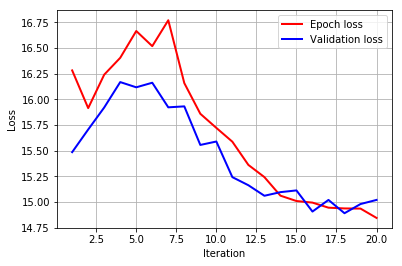

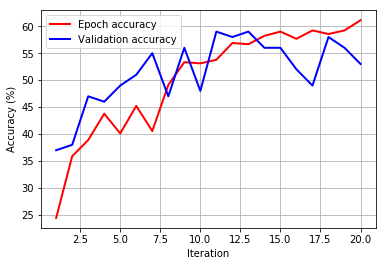

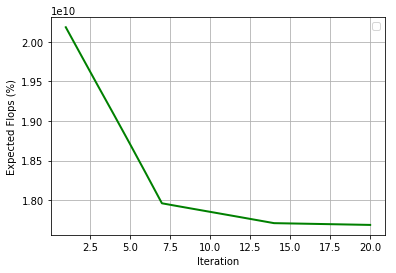

In [10]:
l0_mod, l0_stats = run_normal_training_with_L0_pruning()
PlotResults(l0_stats, "l0_weight_pruning")

In [11]:
def set_params_from_t(model,inparams):
  for name,layer in model.named_children():
    for name_p, p in layer.named_parameters():
      key = str(name)+'.'+name_p
      if key in inparams.keys():        
        p_new = inparams[key].data
#         p_new.requires_grad = True        
#           model[int(name)].weight = p
#         print(model[int(name)]._parameters[name_p])
        model[int(name)]._parameters[name_p].data.copy_(p_new)
#   print(model[6]._parameters[name_p])
  return 

def meta_prune_reptile(trainset, layers_to_prune,outer_steps=10, only_mask=False, inner_steps=5, num_samples=800, inner_lr=0.001,outer_lr=0.001, lamba=0.1, device='cuda'):  
  shuffled_train = torch.utils.data.RandomSampler(trainset)
  train_sample_list = list(torch.utils.data.BatchSampler(shuffled_train,num_samples,False))
  
  train_sample = train_sample_list[0]
  train_data, val_data = torch.utils.data.random_split(train_sample,(int(0.8*num_samples),int(0.2*num_samples)))
  
  dat = DatasetManager(dataset='cifar10', batch_size=5)
  dat.trainset = train_data
  dat.testset = None
  dat.valset = val_data
  dat.GenerateLoaders()

  stats = SettingsNStats()
  MO = L0_Meta_Objective(dat,stats)
  MO.add_L0_layers(layers_to_prune,n=len(dat.trainset))
  
#   MO = L0_Meta_Objective(train_data,val_data)
  
  #make separate inital masks for each layer    
#   MO.add_L0_layers(layers_to_prune,n=200)
  initial_p = {}
  meta_stats  =  SettingsNStats()
  
  for name, param in OrderedDict(MO.model_ft.classifier.named_parameters()).items():
    if re.search('a_logqz',name) or only_mask == False:
      i_p = torch.ones(param.data.size(),requires_grad=False).to(device)
      i_p.copy_(param.data)
      initial_p[name] = i_p

    
  for i in range(1,outer_steps):
    print("new outer ", i)
    train_sample = [trainset[j] for j in train_sample_list[i]] 
    train_data, val_data = torch.utils.data.random_split(train_sample,(int(0.8*num_samples),int(0.2*num_samples)))
    dat = DatasetManager(dataset='cifar10',
                         batch_size = 5
                        )
    dat.trainset = train_data
    dat.testset = None
    dat.valset = val_data
    dat.GenerateLoaders()
    
    stat = SettingsNStats()
    MO = L0_Meta_Objective(dat,stat)
    MO.add_L0_layers(layers_to_prune,n=len(dat.trainset),lamba=lamba)

    new_mod = MO.inner_train_loop(10)
    meta_stats.epoch_loss.append(stat.epoch_loss)
    meta_stats.val_loss.append(stat.val_loss)
    meta_stats.epoch_acc.append(stat.epoch_acc)
    meta_stats.val_acc.append(stat.val_acc)
    meta_stats.flops.append(stat.flops)

    new_p = OrderedDict(MO.model_ft.classifier.named_parameters())
    
    for name, p in initial_p.items():
      update_p = (p - new_p[name].data)/outer_steps*outer_lr
  
      initial_p[name] = p+update_p.data
  
  return meta_stats, initial_p

transform = transforms.Compose(
    [transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# meta_stats, initial_p = meta_prune_reptile(trainset,[0,3,6], outer_steps=50,inner_lr=0.1, outer_lr=0.1) 

Files already downloaded and verified


In [12]:
print(meta_stats.flops)
print(initial_p.keys())

NameError: ignored

In [0]:

meta_stats, initial_p = meta_prune_reptile(trainset,[0,3,6], outer_steps=40,inner_lr=0.1, outer_lr=0.05, lamba=0.5) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


new outer  1
640
Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 28.9622 Acc: 0.1891
201889488.0 100953936.0
val Loss: 28.5297 Acc: 0.1562

Epoch 1/9
----------
train Loss: 27.7562 Acc: 0.3672
val Loss: 27.9124 Acc: 0.2625

Epoch 2/9
----------
train Loss: 27.5690 Acc: 0.4813
val Loss: 27.7111 Acc: 0.4062

Epoch 3/9
----------
train Loss: 27.4666 Acc: 0.5297
val Loss: 27.6690 Acc: 0.4563

Epoch 4/9
----------
train Loss: 27.1174 Acc: 0.6094
val Loss: 27.4901 Acc: 0.4375

Epoch 5/9
----------
train Loss: 26.5734 Acc: 0.6594
181017808.0 90518096.0
val Loss: 27.3303 Acc: 0.4062

Epoch 6/9
----------
train Loss: 26.2021 Acc: 0.7031
val Loss: 26.9660 Acc: 0.4313

Epoch 7/9
----------
train Loss: 25.4907 Acc: 0.8109
val Loss: 26.6264 Acc: 0.4313

Epoch 8/9
----------
train Loss: 25.2894 Acc: 0.8344
val Loss: 26.4402 Acc: 0.4375

Epoch 9/9
----------
train Loss: 24.9784 Acc: 0.8672
val Loss: 26.2944 Acc: 0.4375

Training complete in 3m 56s
Best val Acc: 0.456250
new outer  2
640
Epoch 0/9
----------
train Loss: 28.9995 Acc: 0.1547
201916336.0 1

No handles with labels found to put in legend.


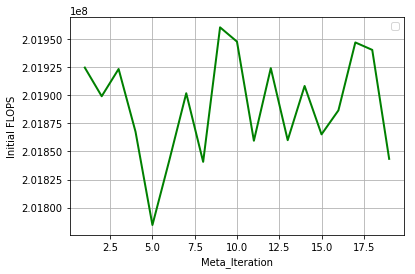

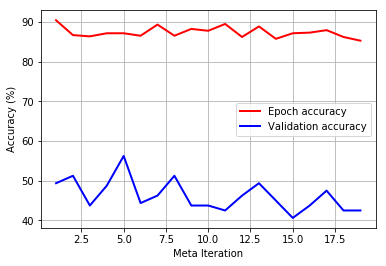

In [15]:
def plot_meta_stats(meta_stats,name):
  final_flops = [x[0] for x in meta_stats.flops]
  final_v_acc = [x[9] for x in meta_stats.val_acc]
  final_e_acc = [x[9] for x in meta_stats.epoch_acc]


  plt.figure()
  plt.plot(np.arange(1, len(final_flops)+1), 
           np.asarray(final_flops), 
           color='green', 
           marker='',  markersize=12, 
           linestyle='-', linewidth=2,
           label='')
  plt.xlabel('Meta_Iteration')
  plt.ylabel('Initial FLOPS')
  plt.grid()
  plt.legend()
  plt.savefig(name+"initial_flops.pdf")


  plt.figure()
  plt.plot(np.arange(1, len(final_e_acc)+1), 
           np.asarray(final_e_acc)*100.0, 
           color='red', 
           marker='',  markersize=12, 
           linestyle='-', linewidth=2,
           label='Epoch accuracy')

  plt.plot(np.arange(1, len(final_v_acc)+1), 
           np.asarray(final_v_acc)*100.0, 
           color='blue', 
           marker='',  markersize=12, 
           linestyle='-', linewidth=2,
           label = 'Validation accuracy')
  plt.xlabel('Meta Iteration')
  plt.ylabel('Accuracy (%)')
  plt.grid()
  plt.legend()

  plt.savefig(name+"final_accuracy.pdf")
  
  
plot_meta_stats(meta_stats, "meta_pruning_02_800")

In [16]:
meta_stats_mask, initial_p_mask = meta_prune_reptile(trainset,[0,3,6], only_mask=True, outer_steps=40,inner_lr=0.1, outer_lr=0.08, lamba=0.5) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


new outer  1
640
Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 28.9384 Acc: 0.1859
201829616.0 100924000.0
val Loss: 27.8325 Acc: 0.3188

Epoch 1/9
----------
train Loss: 27.6224 Acc: 0.4078
val Loss: 27.8349 Acc: 0.2438

Epoch 2/9
----------
train Loss: 27.5250 Acc: 0.4750
val Loss: 27.7268 Acc: 0.4125

Epoch 3/9
----------
train Loss: 27.0728 Acc: 0.5844
val Loss: 27.7949 Acc: 0.3625

Epoch 4/9
----------
train Loss: 26.7740 Acc: 0.6328
val Loss: 27.8114 Acc: 0.3688

Epoch 5/9
----------
train Loss: 26.5588 Acc: 0.6656
180464672.0 90241528.0
val Loss: 27.3688 Acc: 0.3563

Epoch 6/9
----------
train Loss: 26.1213 Acc: 0.6953
val Loss: 26.9327 Acc: 0.3750

Epoch 7/9
----------
train Loss: 25.3653 Acc: 0.8031
val Loss: 26.5743 Acc: 0.4563

Epoch 8/9
----------
train Loss: 25.0305 Acc: 0.8641
val Loss: 26.3945 Acc: 0.4375

Epoch 9/9
----------
train Loss: 24.8532 Acc: 0.8531
val Loss: 26.2727 Acc: 0.4625

Training complete in 3m 57s
Best val Acc: 0.462500
new outer  2
640
Epoch 0/9
----------
train Loss: 28.9077 Acc: 0.1688
201849808.0 1

No handles with labels found to put in legend.


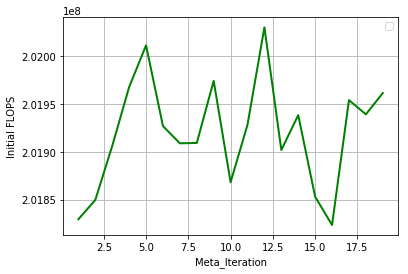

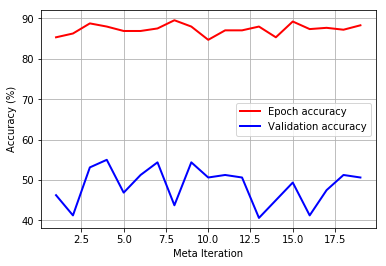

In [18]:
plot_meta_stats(meta_stats_mask, "mask_meta_pruning_05_800")

In [0]:
meta_stats_mask, initial_p_mask = meta_prune_reptile(trainset,[0,3,6], only_mask=True, outer_steps=40,inner_lr=0.1, outer_lr=0.08, lamba=0.5) 